# How to extract Historical Data from a Drift device

_PANDA|Drift_ keeps a history of input data that might be images from CV cameras, sensor data or metrics.
In this tutorial you will learn:

1. How to connect a Drift device and explore topics
2. How to download and parse a Drift Package
3. How to extract an image from a CV camera
4. How to extract time series data from an acceleration sensor
5. Hot to get metrics

## Connect and explore topics

To connect to a device, you need to know its hostname or IP address and password:

In [210]:
import os
from drift_client import DriftClient

drift_client = DriftClient("drift-test-rig.local", os.getenv("DRIFT_PASSWORD"))

print(drift_client.get_topics())

['acc-0', 'acc-1', 'acc-2', 'acc-3', 'acc-4', 'acc-5', 'acc-6', 'acc-7', 'camera', 'energy-distr-0', 'energy-distr-1', 'energy-distr-2', 'energy-distr-3', 'energy-distr-4', 'energy-distr-5', 'energy-distr-6', 'energy-distr-7']


You can see that the Drift device has few topics. Unfortunately, the device doesn't provide information about the type, and you should know it in advance. Here we have 8 acceleration signals (time series), 8  energy distributions (metrics of accelerations) and one camera (images).

## Download and parse a Drift package
When you know a topic name you can load some batch of packages for a time interval. Let's take packages of camera data for the last 5 seconds:

In [211]:
from datetime import datetime, timedelta

package_names = drift_client.get_package_names(
    "camera", datetime.utcnow() - timedelta(seconds=5), datetime.utcnow()
)
print(f"Found {len(package_names)} packages")
print(package_names)

Found 4 packages
['camera/1661949756707.dp', 'camera/1661949757708.dp', 'camera/1661949758708.dp', 'camera/1661949759708.dp']


We should take ~5 packages because we capture an image each second. Let's download one from our object storage and parse it:

In [212]:
pkg = drift_client.get_item(package_names[0])
print(f"Download package id={pkg.package_id} status={pkg.status_code}")

Download package id=1661949756707 status=0


All packages have at least an `ID` and `status code`. The package ID is unique for a topic, it is a timestamp when an event in the system happened. If you know that topic 'A' has metrics for data from topic 'B' they will have the same IDs, so that you can align data from different topics that belong to the same event. A package has the status code 0 if it has valid data.

## Extract an image from a CV camera
Because we download a Drift package it always contains [WaveletBuffer](https://github.com/panda-official/WaveletBuffer). Let's take it and play a bit with:

In [213]:
buffer = pkg.as_buffer()
print(buffer)

WaveletBuffer<signal_number=3, signal_shape=(1920x1200), decomposition_steps=4, wavelet_type=WaveletType.DB3>




From the previous step, we see that the buffer has some meta information about itself, and we can see that it contains a fullHD 3-channeled picture. We can extract it as a numpy array and encode into a JPEG image:

Scaled image (3, 600, 960)


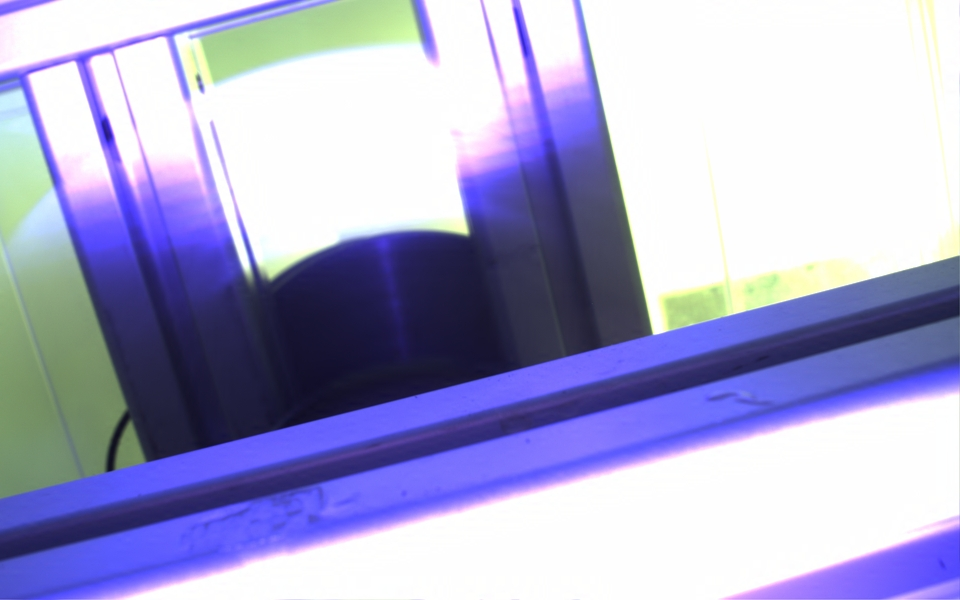

In [214]:
from wavelet_buffer.img import RgbJpeg, GrayJpeg
from IPython.display import Image

pic = buffer.compose(
    scale_factor=1
)  # we may use scale factor and restore 2^scaler_factor times smaller version of image

print(f"Scaled image {pic.shape}")
jpeg = RgbJpeg().encode(pic)
Image(data=jpeg)

## Extract time series from an acceleration sensor
We can also use the wavelet decomposition for time series data when we have a very high sample rate (vibration or sound e.g). In our demo system we have 8 acceleration sensors `acc-{0..7}`. Let's take one of them and see what is inside:

In [215]:
package_names = drift_client.get_package_names(
    "acc-1", datetime.utcnow() - timedelta(seconds=5), datetime.utcnow()
)
pkg = drift_client.get_item(package_names[0])
buffer = pkg.as_buffer()
print(buffer)

WaveletBuffer<signal_number=1, signal_shape=(48199), decomposition_steps=9, wavelet_type=WaveletType.DB3>


The buffer contains a timeseries with ~48k points, we can show its scaled version:

Scaled size (376,)


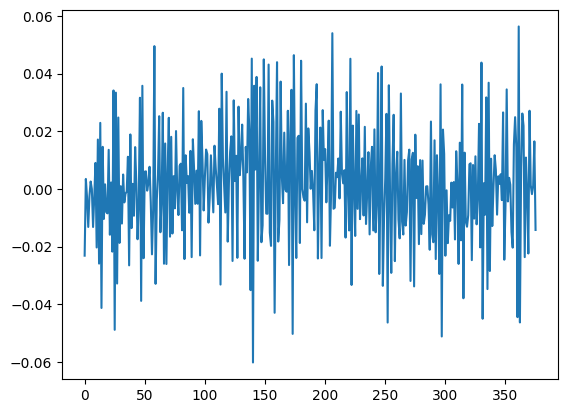

In [216]:
signal = buffer.compose(scale_factor=7)
print(f"Scaled size {signal.shape}")

import matplotlib.pyplot as plt

plt.plot(signal)
plt.show()

## Get metrics
The _PANDA|Drift_ platform keep a history of metrics separated from input data. So, a user should use a different API to get them.

In our example, we have energy distributions (like frequency spectrums) of the acceleration senors as metrics. We can use the `get_metrics` method to download them:

In [217]:
metrics = drift_client.get_metrics(
    "energy-distr-1",
    start=datetime.utcnow() - timedelta(seconds=3),
    stop=datetime.utcnow(),
)

print(metrics)

[{'a9': 2.2440512, 'count': 11, 'd1': 0.7816209, 'd2': 14.081247, 'd3': 75.99819, 'd4': 524.39197, 'd5': 2540.4023, 'd6': 3329.1064, 'd7': 435.42175, 'd8': 24.471087, 'd9': 7.561126, 'status': 0, 'total': 6954.46, 'time': 1661949759.708}, {'a9': 3.9742975, 'count': 11, 'd1': 0.9278174, 'd2': 15.316552, 'd3': 76.30971, 'd4': 621.19165, 'd5': 2561.5679, 'd6': 3402.1606, 'd7': 606.6536, 'd8': 21.552977, 'd9': 5.453621, 'status': 0, 'total': 7315.1084, 'time': 1661949760.708}, {'a9': 1.5598903, 'count': 11, 'd1': 0.81918865, 'd2': 13.783999, 'd3': 74.701584, 'd4': 648.4096, 'd5': 2576.0054, 'd6': 3331.447, 'd7': 512.77356, 'd8': 20.335003, 'd9': 3.4346893, 'status': 0, 'total': 7183.2695, 'time': 1661949761.708}]


Here is a short example of how to plot a bar diagram of an energy distribution.

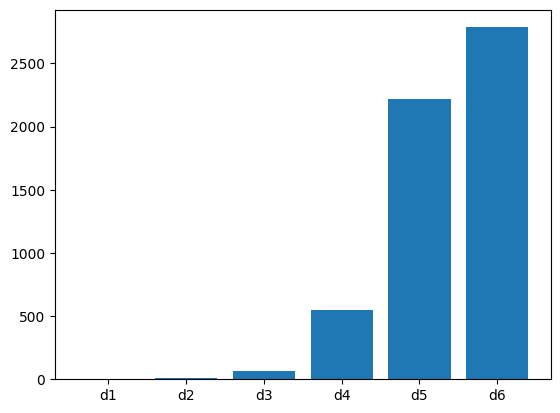

In [218]:
energies = drift_client.get_metrics(
    "energy-distr-1",
    start=datetime.utcnow() - timedelta(seconds=5),
    stop=datetime.utcnow(),
    names=["d1", "d2", "d3", "d4", "d5", "d6"],
)

as_dict = dict(energies[0])
as_dict.pop("time")
plt.bar(as_dict.keys(), as_dict.values())
plt.show()